In [15]:
import pandas as pd # For DataFrame manipulation (assuming df_clean is loaded)
import numpy as np # For numerical operations, especially for handling arrays
from scipy.special import softmax # For converting logits to probabilities

clean_file_path = r"C:\Users\comat\GitProjects\customer-churn-ai\data\cleaned_telco_churn.csv"

try:
    df_hf = pd.read_csv(clean_file_path)
    print("Data Loaded Successfully! Sensational!")
except FileNotFoundError:
    print(f"Error: File not found at {clean_file_path}. Please check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

Data Loaded Successfully! Sensational!


In [16]:
# From Hugging Face transformers library
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig # To access model configuration like label mappings
print("Necessary libraries imported.")

Necessary libraries imported.


In [17]:
# Define the model name
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load the tokenizer
print(f"Loading tokenizer for {MODEL}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL)
print("Tokenizer loaded successfully.")

# Load the model
print(f"\nLoading model for {MODEL}...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
print("Model loaded successfully.")

Loading tokenizer for cardiffnlp/twitter-roberta-base-sentiment-latest...
Tokenizer loaded successfully.

Loading model for cardiffnlp/twitter-roberta-base-sentiment-latest...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded successfully.


In [18]:
# Optional: You can also load the model's configuration if needed to inspect details like label mappings
config = AutoConfig.from_pretrained(MODEL)
print("\nModel configuration loaded (optional).")
print(f"Labels in model config: {config.id2label}") # This will show how the model internally maps numeric IDs to labels


Model configuration loaded (optional).
Labels in model config: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [19]:
def predict_sentiment_advanced(text):
    """
    Predicts sentiment for a given text using the loaded RoBERTa model,
    returning probabilities for all classes and the predicted label.
    """
    if not isinstance(text, str) or not text.strip():
        # Handle empty strings or non-string inputs if necessary
        # Return a default neutral sentiment or NaN values
        return {
            'HF_neg': 0.0,
            'HF_nue': 1.0, # Defaulting to neutral for empty/bad input
            'HF_pos': 0.0,
            'HF_Label': 'Neutral' # Or perhaps 'Unknown' or np.nan
        }

    # Tokenize the text
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    # If you have a GPU and set up PyTorch for it, you might move inputs to GPU here:
    # encoded_input = {k: v.to(model.device) for k, v in encoded_input.items()}

    # Get model output (logits)
    output = model(**encoded_input)
    logits = output.logits

    # Process logits to get probabilities
    scores_np = logits.detach().cpu().numpy()[0]  # Get scores for the first (and only) input
    probabilities = softmax(scores_np)

    # Get the predicted class index
    predicted_class_id = np.argmax(probabilities)
    
    # Map class ID to label string using model's config
    predicted_label = model.config.id2label[predicted_class_id] # Or use the 'config' object directly if loaded separately

    # Store probabilities for each class (order depends on config.id2label)
    # Assuming config.id2label is {0: 'negative', 1: 'neutral', 2: 'positive'}
    # You can make this more robust by iterating through config.id2label if order is not guaranteed
    # but for this model, it's standard.
    prob_negative = probabilities[0]
    prob_neutral = probabilities[1]
    prob_positive = probabilities[2]

    return {
        'HF_neg': prob_negative,
        'HF_nue': prob_neutral,
        'HF_pos': prob_positive,
        'HF_Label': predicted_label.capitalize() # Capitalize for consistency e.g. "Negative"
    }

# Example usage (optional - just to test the function with one review):
# test_review = "This is a fantastic service, I am very happy!"
# test_sentiment = predict_sentiment_advanced(test_review)
# print(f"Sentiment for '{test_review}': {test_sentiment}")

# test_review_neg = "This is a terrible service, I am very unhappy!"
# test_sentiment_neg = predict_sentiment_advanced(test_review_neg)
# print(f"Sentiment for '{test_review_neg}': {test_sentiment_neg}")

print("Function 'predict_sentiment_advanced' defined.")

Function 'predict_sentiment_advanced' defined.


---
Test Run below

In [20]:
# Example usage (optional - just to test the function with one review):
test_review = "This is a fantastic service, I am very happy!"
test_sentiment = predict_sentiment_advanced(test_review)
print(f"Sentiment for '{test_review}': {test_sentiment}")

test_review_neg = "This is a terrible service, I am very unhappy!"
test_sentiment_neg = predict_sentiment_advanced(test_review_neg)
print(f"Sentiment for '{test_review_neg}': {test_sentiment_neg}")

Sentiment for 'This is a fantastic service, I am very happy!': {'HF_neg': np.float32(0.0046059242), 'HF_nue': np.float32(0.0066346405), 'HF_pos': np.float32(0.9887594), 'HF_Label': 'Positive'}
Sentiment for 'This is a terrible service, I am very unhappy!': {'HF_neg': np.float32(0.9494115), 'HF_nue': np.float32(0.04334269), 'HF_pos': np.float32(0.0072457953), 'HF_Label': 'Negative'}


---
Apply Function to entire column

In [21]:
print(f"Applying advanced sentiment analysis to all {len(df_hf)} reviews... (This may take several minutes)")

# Apply the function to the 'CustomerReview' column
# This will return a Series of dictionaries
sentiment_results_series = df_hf['CustomerReview'].apply(predict_sentiment_advanced)

# Convert the Series of dictionaries into a DataFrame
df_sentiment_advanced = pd.DataFrame(sentiment_results_series.tolist(), index=df_hf.index)

# Concatenate the new sentiment columns with the original df_hf
df_hf = pd.concat([df_hf, df_sentiment_advanced], axis=1)

print("\nAdvanced Hugging Face sentiment scores and labels added to df_hf.")

Applying advanced sentiment analysis to all 7043 reviews... (This may take several minutes)

Advanced Hugging Face sentiment scores and labels added to df_hf.


In [22]:
columns_to_show_adv = [
    'CustomerReview',
    'HF_Label',        # The predicted label from predict_sentiment_advanced
    'HF_neg', # The probability for Negative
    'HF_nue',  # The probability for Neutral
    'HF_pos'  # The probability for Positive
]
print("\nDataFrame with new sentiment columns (first 5 rows):")
print(df_hf[columns_to_show_adv].head())


DataFrame with new sentiment columns (first 5 rows):
                                      CustomerReview  HF_Label    HF_neg  \
0  Really happy with my plan... no unexpected fee...  Positive  0.005294   
1  Really happy with my plan... phone support was...  Positive  0.004702   
2  Unfortunately, my service was... frustrated by...  Negative  0.906199   
3  Consistently good signal... data plan is a gre...  Positive  0.004989   
4  Not satisfied with the billing... billing erro...  Negative  0.930403   

     HF_nue    HF_pos  
0  0.021416  0.973291  
1  0.012738  0.982560  
2  0.086496  0.007306  
3  0.034239  0.960772  
4  0.060820  0.008777  


In [29]:
print("\nDistribution of Hugging Face Sentiment Labels (adv):")
print(df_hf["HF_Label"].value_counts())

print("\nDistribution of Hugging Face Sentiment as Percentages (adv):")
hf_percents = df_hf["HF_Label"].value_counts(normalize=True) * 100
print(hf_percents.round(3))


Distribution of Hugging Face Sentiment Labels (adv):
HF_Label
Positive    5177
Negative    1818
Neutral       48
Name: count, dtype: int64

Distribution of Hugging Face Sentiment as Percentages (adv):
HF_Label
Positive    73.506
Negative    25.813
Neutral      0.682
Name: proportion, dtype: float64


In [30]:
df_hf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


---
Save DataFrame 'df_hf' as 'telco_churn_with_hf_sentiment.parquet'

In [32]:
# Save to Parquet
parquet_file_path = r"C:\Users\comat\GitProjects\customer-churn-ai\data\telco_churn_with_hf_sentiment.parquet" # Storing in your data folder

try:
    df_hf.to_parquet(parquet_file_path, index=False) # index=False if you don't want to save the DataFrame index
    print(f"DataFrame successfully saved to: {parquet_file_path}")
except Exception as e:
    print(f"Error saving to Parquet: {e}")
# C:\Users\comat\GitProjects\customer-churn-ai\data\

DataFrame successfully saved to: C:\Users\comat\GitProjects\customer-churn-ai\data\telco_churn_with_hf_sentiment.parquet


---
Data Visualization

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

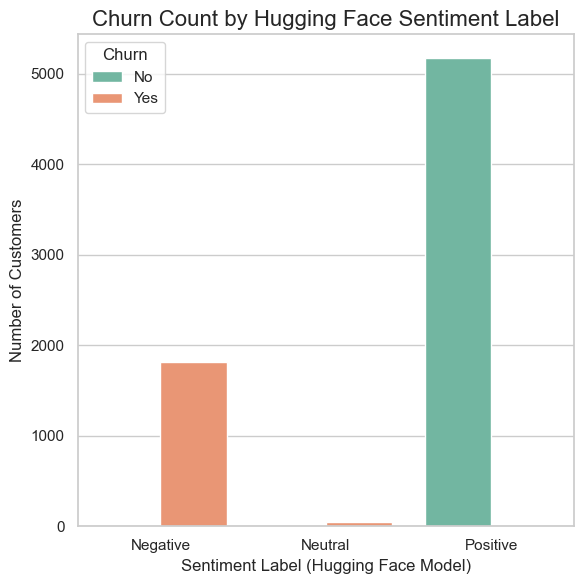

In [55]:
# Set the style of seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 6)) # Set the figure size and adjust as needed
# Create a count plot for the HF_Label column
sns.countplot(data=df_hf, x='HF_Label', hue='Churn', palette='Set2',
              order=['Negative', 'Neutral', 'Positive'])

plt.title('Churn Count by Hugging Face Sentiment Label', fontsize=16)
plt.xlabel('Sentiment Label (Hugging Face Model)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn')
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()